# SOFR curve building

In this code we will bootstrap SOFR curve with some simplifying assumptions described below.

In [253]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

#### The curve building instrument types include 

- SOFR spot rate
- 1-month SOFR futures (SR1)
- 3-month SOFR futures (SR3)
- and SOFR swaps (SWP)

It is important to remember that 1M and 3M SOFR futures conventios differ.

#### We will create three pricing functions

- sofr_1m_fut - to price 1M SOFR futures
- sofr_3m_fut - to price 3M SOFR futures
- sofr_swap   - to price SOFR swaps

#### The idea is to build a code that will utilize 

- spot SOFR rate
- 1-month SOFR futures expiring prior to the expiration of the front 3M SOFR futures
- 3-month futures up to 21 months into the future
- only SOFR swaps from 2 years and on

#### Here are some conventions associated with different instruments

- SOFR 1-month futures rates are simple rates
- SOFR 3-month futures rates are compounded daily
- SOFR swap rates are based on the daily resets and annual payments
- SOFR forward rates are recorded in % units (e.g. 0.04% is equivalent to .0004 or 4 bps)

#### In this code we are using the following simplifying assumptions

- no holidays, only weekends
- constant forward interpolation
- no convexity adjustments

#### Data inputs

In the code below, we will bootstrap SOFR forward curve as of 04/30/2020. We will be using realized SOFR rates along with prices of the instruments (such as SR1, SR3, etc.) to bootstrap the unknown SOFR rates. The user will need to modify the inputs accordingly. 

In our code we will use the following notation for SR1 and SR3 futures. The front SR1 and SR3 futures will be denoted as SR1-0 and SR3-0. The other ones, will be sorted/denoted according to their marutiy dates SR3-1, SR3-2, etc.

In our case, the front SR1-0 futures expires on 04/30/2020 and is equivalent to the SOFR spot rate. The second SR1 futures (SR1-1) expires on 5/29/2020. And this is the only SR1 futures that we will use since the front SR3-0 futures expires on 06/16/2020. There will be 6 more SR3 futures (SR3-1 through SR3-6) with SR3-6 futures maturing on 12/15/2021. 

We will also use SOFR swap rates starting from 2 years through 40 years (SWP-2Y through SWP-40Y).

## Step 1 - spot SOFR rate

Let's define forward SOFR curve and record the spot rate that was observed in the market. This SOFR rate can be found on the NY Fed page.

https://apps.newyorkfed.org/markets/autorates/SOFR

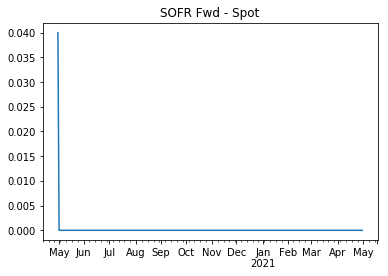

In [254]:
# User needs to input the start date (the as of date) and end date for the SOFR curve
fwd_dates = pd.bdate_range(start='04/30/2020', end='04/30/2060')
fwd_rates = np.array([0]*len(fwd_dates))
fwd_rates = pd.Series(fwd_rates, index=fwd_dates)
# User needs to input this rate
fwd_rates.iloc[0] = .04 
fwd_rates[fwd_rates.index <='04/30/2021'].plot(title='SOFR Fwd - Spot')
# fwd_rates.head()

## Step 2 - SR1 futures

SR1 quotes can be pulled from CME page.

https://www.cmegroup.com/trading/interest-rates/stir/one-month-sofr_quotes_globex.html

We pulled the data as of 04/30/2020 into a csv file.

In [255]:
sr1_data = pd.read_csv("1m_futures_data.csv", header=0, index_col=0)
sr1_data

,Product Code,First Trade,Last Trade,Settlement,Price
Contract Month,,,,,
May-20,SR1K20,9/30/2019,5/29/2020,6/1/2020,99.9775


SOFR futures are traded at CME and include 1M and 3M tenors. The 3M futures and traditional Eurodollar (ED) futures share similar reference quarters but different re-setting convention. $SR_1$ pricing formula can be seen below.

$ 1 - SR_1-CA=\frac{1}{N_m}\sum_{i=1}^{N_m} SOFR_{t_i}^{Fwd} $

As stated earlier in the assumptions section, we will ignore convexity adjustments ($CA$) in this code. $N_m$ represents a number of days in a contract month. Since we are using constant forward assumption, all $SOFR_{t_i}^{Fwd}$ rates are assumed to be the same and we obtain the following formula.

$ SOFR_{t_i}^{Fwd} = N_m(1-SR_1) $

In [256]:
# set_rates function will allow us to easily overwrite unknown SOFR forward rates
def set_rates(fwd_rates, rate, start, end):
    fwd_rates[(fwd_rates.index >= start) & (fwd_rates.index <= end)]=rate
    return fwd_rates

In [257]:
def sr1_pricer(sofr_fwd, N_days, days_passed=0, sr1_rzd=0):
    '''
    sr1 is a pricing function that will allow us to imply SOFR forward rates
    
    sofr_fwd - is the unknown forward rate that we will be solving for
    N_days - the number of days in the contract month
    days_passed - the number of days in passed (if supplied)
    sr1_rzd - is the accrued portion of the front SR1-0 futures (if supplied)
    ''' 
    
    sr1 = 100 - (sr1_rzd + (N_days - days_passed)*sofr_fwd) / N_days
    
    return sr1

def sr1_boot(quote, N_days, days_passed=0, sr1_rzd=0):
    result = ((100-quote)*N_days-sr1_rzd)/(N_days - days_passed)
    return result

SOFR futures pricing is straigtforward, however, the major difference between ED futures and SOFR futures is on the front contract. The SOFR realized rates up to the current time $t$ in the reference month(SR1)/quarter(SR3) need to be considerred in the pricing formula.

$ 1-SR_{1}=\frac{1}{N_m}\sum_{i=1}^{N_m} (SOFR_{t_i<t}^{Rzd}+ SOFR_{t_i\geq t}^{Fwd} )$

On 04/30/2020, the SR1-0 futures expires and the last forward rate is determined. Hence, we will simply use the spot SOFR rate without bootstrapping this info from the expiring front SR1-0 futures. However, we use the next SR1-1 futures to bootstrap rates through May of 2020.

In [277]:
sr1_boot(99.981, 21, 20, .37), sr1_pricer(.04, 21, 20, .37)

(0.0290000000001146, 99.9804761904762)

The spot SOFR rate 0f .04% (4bps) implies SR1-0 price of 99.98. The actual market quote was 99.981 which leads to the SOFR spot of .029% (3bps). We will use the market spot SOFR rate of .04%.

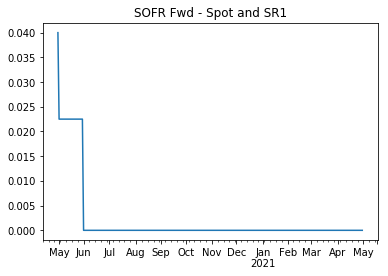

In [259]:
#fwd_rates = set_rates(fwd_rates, sr1_boot(99.981, 21, 20, .37), '04/30/2020', '04/30/2020')
fwd_rates = set_rates(fwd_rates, sr1_boot(99.9775, 21), '05/01/2020', '05/29/2020')
fwd_rates[fwd_rates.index <='04/30/2021'].plot(title='SOFR Fwd - Spot and SR1')

## Step 3 - SR3 futures

SR3 quotes can be pulled from CME page.

https://www.cmegroup.com/trading/interest-rates/stir/three-month-sofr_quotes_globex.html

We pulled the data as of 04/30/2020 into a csv file.

In [260]:
sr3_data = pd.read_csv("3m_futures_data.csv", header=0, index_col=0)
sr3_data

,Product Code,First Trade,Last Trade,Settlement,Price
Contract Month,,,,,
Mar-20,SR3H20,4/23/2018,6/16/2020,6/17/2020,99.985
Jun-20,SR3M20,4/23/2018,9/15/2020,9/16/2020,99.975
Sep-20,SR3U20,4/23/2018,12/15/2020,12/16/2020,99.970
Dec-20,SR3Z20,4/23/2018,3/16/2021,3/17/2021,99.960
Mar-21,SR3H21,4/23/2018,6/15/2021,6/16/2021,99.950
Jun-21,SR3M21,4/23/2018,9/14/2021,9/15/2021,99.945
Sep-21,SR3U21,4/23/2018,12/14/2021,12/15/2021,99.940


The first 3M SOFR futures (SR3-0) that we will use for bootstrapping starts on 03/18/2020, the last one we will be using ends on 12/15/2021. As discussed earlier, it matures at least 3 month prior to the start of the 2-year SOFR swap.

The first futures price can be calculated as follows.

$ 1-SR_{3}=\frac{360}{N_{Q}}\left(\prod_{i=1}^{Q}(SOFR_{t_i < t}^{Rzd}*\frac{dt_i}{360}+1)\prod_{i=1}^{Q}(SOFR_{t \leq t_i < t'}^{Btd}*\frac{dt_i}{360}+1) \prod_{i=1}^{Q}(SOFR_{t_i\geq t'}^{Fwd}*\frac{dt_i}{360}+1)-1\right) $

$N_Q$ is the number of days in a reference quarter. Notice that $dt_i$ is not necessarily 1/360 due to weekends and holidays. For example, on Friday it will be 3/360. As one can see in the formula above, there are three types of SOFR forward rates - realized rates (that were determined in the past $t_i<t$) and unrealzied rates (spot rate at $t_i=t$ and future rates at $t_i > t$). Some of the unrealized SOFR rates have been bootstraped in the earlier steps using spot SOFR and SR1 (at $t \leq t_i < t'$). We will use those bootstrapped values.

Starting from the second futures and on (SR1-1 through SR1-6), one does not need to deal with the realized and pre-bootstrapped rates. Hence, their prices can be calculated using a simpler formula.

$ 100-SR_{3}=\frac{360}{N_{Q}}\left(\prod_{i=1}^{Q}(SOFR_{t_i}^{Fwd}*\frac{dt_i}{360}+1)-1\right) $

#### Realized SOFR rates
$
\prod_{i=1}^{Q}(SOFR_{t_i < t}^{Rzd}*\frac{dt_i}{360}+1)
$

In [261]:
rzd_rates = pd.read_csv("rzd_rates.csv", index_col=0)
rzd_rates.index = pd.to_datetime(rzd_rates.index)
dt_rzd = pd.Series(rzd_rates.index).diff().dt.days/360
dt_rzd = dt_rzd[1:]
#dt_rzd
rzd_rates = rzd_rates[:-1]
#rzd_rates, dt_rzd
sr3_rzd = (np.transpose(rzd_rates.values)*dt_rzd.values+1).prod()
sr3_rzd

1.0025586048829431

#### Pre-bootstrapped SOFR rates
$
\prod_{i=1}^{Q}(SOFR_{t \leq t_i < t'}^{Btd}*\frac{dt_i}{360}+1)
$

In [262]:
btd_rates = fwd_rates[0:23]

dt_btd = pd.Series(btd_rates.index).diff().dt.days/360
dt_btd = dt_btd[1:]
#dt_rzd
btd_rates = btd_rates[:-1]
btd_rates, dt_btd
sr3_btd = (np.transpose(btd_rates.values)*dt_btd.values+1).prod()
sr3_btd

1.0020505853908581

#### SR3 pricing function

Now we are ready to combine the three pieces together (realized, pre-bootstrapped, and unknown) to price front SOFR futures SR3-0.

In [263]:
def sr3_pricer(sofr_fwd, quote, start, end, sr3_rzd=1, sr3_btd=1):
    """
    sr3 is a pricing function that will allow us to imply SOFR forward rates
    
    sofr_fwd is the unknown forward rate that we will be solving for
    sr3_rzd is the accrued portion of the front SR3-0 futures (if supplied)
    """
    fwd_dates = pd.bdate_range(start, end)
    dt_fwd = pd.Series(fwd_dates).diff().dt.days/360
    dt_fwd = dt_fwd[1:]

    sr3_pricer = (sr3_btd*sr3_rzd*(sofr_fwd*dt_fwd+1).prod()-1)*360/90

    return sr3_pricer

def sr3_min(sofr_fwd, sr3_pricer, quote, start, end, sr3_rzd=1, sr3_btd=1):
    return 1000000*(100 - quote - sr3_pricer(sofr_fwd, quote, start, end, sr3_rzd=1, sr3_btd=1))**2

We will use minimizer to derive the unknown forward rate.

In [264]:
results = minimize(sr3_min, .0004, 
                   args=(sr3_pricer, 99.985, '06/01/2020', '06/17/2020', sr3_rzd, sr3_btd), method="SLSQP",
                   options={'disp': False}
                  )
results.x

array([0.08423442])

In [265]:
fwd_rates = set_rates(fwd_rates, results.x, '06/01/2020', '06/16/2020')
#fwd_rates

In the following loop, we will derive forward rates based on the remaining SR3 futures.

In [266]:
quote_set = sr3_data.iloc[1:7,4]
#print(quote_set)
start_set = sr3_data.iloc[0:6,3]
#print(start_set) 
end_set = sr3_data.iloc[1:7,3]
#print(end_set)
last_set = sr3_data.iloc[1:7,2]
print(last_set)
fwd_rates_sr3 = []
for i in range(len(start_set)):
    quote = quote_set[i]
    start = start_set[i]
    end = end_set[i]
    last = last_set[i]
    results = minimize(sr3_min, .0004, 
                   args=(sr3_pricer, quote, start, end), method="SLSQP",
                   options={'disp': False}
                  )
    # we will keep over-writing unknown forward rates with the ones implied from SR3 futures
    fwd_rates = set_rates(fwd_rates, results.x, start, last)
    fwd_rates_sr3.append(results.x)
        
fwd_rates_sr3

Contract Month
Jun-20     9/15/2020
Sep-20    12/15/2020
Dec-20     3/16/2021
Mar-21     6/15/2021
Jun-21     9/14/2021
Sep-21    12/14/2021
Name: Last Trade, dtype: object


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars


[array([0.02464989]),
 array([0.02956187]),
 array([0.03936794]),
 array([0.04915026]),
 array([0.05403255]),
 array([0.05890894])]

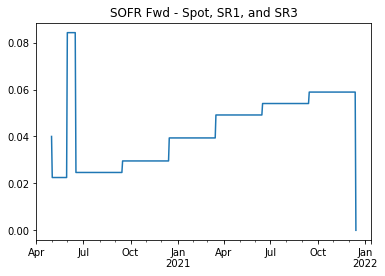

In [267]:
#print(fwd_rates[0:100])
fwd_rates[fwd_rates.index <= '12/15/2021'].plot(title='SOFR Fwd - Spot, SR1, and SR3')

## Step 4 - SOFR Swaps

For a swap starting at time $t=T_0$ and maturity $T$, resets occur daily at times $t_i$, while payments occur annually at times $T_j$. The swap rate $K$ is a solution of the following equation.

$ \sum_j\left(\prod_i(1+SOFR_{T_{j-1}<t_i\leq T_j}*\frac{dt_i}{360})-1\right)*\frac{360}{dT_j}*P(0,T_{j}) =\sum_j K
*P(0,T_j)$

$SOFR_{T_{j-1}<t_i\leq T_j}$ represents all the bootstrapped and forward SOFR rates within year $T_j$ ($t_i\in (T_{j-1},T_j]$). It is easy to see that $\sum_{T_{j-1}<t_i\leq T_j}{t_{i}}=T_j$. 

As in the earlier cases, one needs to keep track of the rates that have been bootstrapped earlier. For the first two-year SOFR swap (SWP-2Y), all rates in year one as well as some rates from year 2 have been bootstrapped earlier. We will need to calculate those first.

In [268]:
# Calculations associated with the rates that have been bootstrapped earlier
btd_y1_dates = pd.bdate_range('04/30/2020', '05/03/2021') 
dt_btd_y1 = pd.Series(btd_y1_dates).diff().dt.days/360
dt_btd_y1 = dt_btd_y1[1:]
#print(dt_btd_y1)
btd_y1_rates = fwd_rates[fwd_rates.index <= '04/30/2021']/100
swap_btd_y1 = (np.transpose(btd_y1_rates.values)*dt_btd_y1.values+1).prod()

btd_y2_dates = pd.bdate_range('05/03/2021', '12/15/2021')
dt_btd_y2 = pd.Series(btd_y2_dates).diff().dt.days/360
dt_btd_y2 = dt_btd_y2[1:]

btd_y2_rates = fwd_rates[(fwd_rates.index <= '12/14/2021') & (fwd_rates.index > '04/30/2021')]/100
swap_btd_y2 = (np.transpose(btd_y2_rates.values)*dt_btd_y2.values+1).prod()

swap_btd_y1, swap_btd_y2, 1/swap_btd_y1, 1/swap_btd_y1/swap_btd_y2

(1.0003587046312719, 1.0003456227538325, 0.999641423991603, 0.9992960445407949)

In [269]:
def swap_pricer(sofr_fwd, swap_rate, unknown_rate_date, end, swap_btd_y1=1, swap_btd_y2=1):
    """
    sofr_swap is a pricing function that will allow us to imply SOFR forward rates from SOFR swaps
    
    sofr_fwd is the unknown forward rate that we will be solving for
    swap_btd_y1/y2 is the cash flow portion based on the bootstrapped rates (if supplied)
    """
      
    fwd_dates = pd.bdate_range(unknown_rate_date, end)
    dt_fwd = pd.Series(fwd_dates).diff().dt.days/360
    dt_fwd = dt_fwd[1:]

    sofr_swap_y1 = (swap_btd_y1-1)*360/365/swap_btd_y1-swap_rate/swap_btd_y1
    sofr_swap_y2 = (swap_btd_y2*(sofr_fwd*dt_fwd+1).prod()-1)*360/365 \
    /(swap_btd_y1*swap_btd_y2*(sofr_fwd*dt_fwd+1).prod())\
    -swap_rate/(swap_btd_y1*swap_btd_y2*(sofr_fwd*dt_fwd+1).prod())
    sofr_swap = sofr_swap_y1 + sofr_swap_y2
    print(sofr_swap_y1, sofr_swap_y2)
    #return 1000000*sofr_swap**2
    return sofr_swap_y1, sofr_swap_y2

def swap_min(sofr_fwd, swap_pricer, swap_rate, unknown_rate_date, end, swap_btd_y1=1, swap_btd_y2=1):
    sofr_swap_y1, sofr_swap_y2 = sofr_swap(sofr_fwd, swap_rate, unknown_rate_date, end, swap_btd_y1, swap_btd_y2)
    return 1000000*(sofr_swap_y1+sofr_swap_y2)**2

In [270]:
results = minimize(sofr_swap_min, .04,  
                   args=(sofr_swap, .00046, '12/15/2021', '05/03/2022', swap_btd_y1, swap_btd_y2), method="SLSQP",
                   options={'disp': False}
                  )
results.x

-0.00010617104675418387 0.01499167231444325
-0.00010617104675418387 0.01499167231444325
-0.00010617104675418387 0.01499167789967945
-0.00010617104675418387 0.9859477058547316
-0.00010617104675418387 0.9859477058547317
-0.00010617104675418387 0.9859477058547317
-0.00010617104675418387 0.9859477058547318
-0.00010617104675418387 1.0590678013355985
-0.00010617104675418387 -3.0835804740744538e+44
-0.00010617104675418387 -63873.432278386994
-0.00010617104675418387 -1.7495375172377547
-0.00010617104675418387 -0.09027523478578643
-0.00010617104675418387 0.0012985529790906964
-0.00010617104675418387 0.0012985529790906964
-0.00010617104675418387 0.0012985586441693496
-0.00010617104675418387 7.823629683123556e-05
-0.00010617104675418387 7.823629683123556e-05
-0.00010617104675418387 7.824196901051945e-05
-0.00010617104675418387 0.00010621957084787635
-0.00010617104675418387 0.00010621957084787635
-0.00010617104675418387 0.00010622524287908869


array([0.00059169])

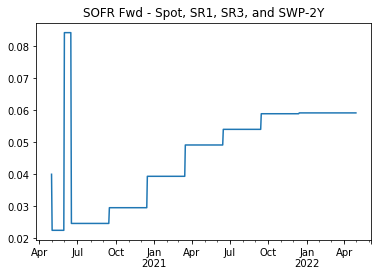

In [271]:
fwd_rates = set_rates(fwd_rates, 100*results.x, '12/15/2021', '04/29/2022')
fwd_rates[fwd_rates.index <= '04/29/2022'].plot(title='SOFR Fwd - Spot, SR1, SR3, and SWP-2Y')

A 2-year SOFR swap can be viewed as a sum of present values of the year 1 and year 2 cash flows (floating leg minus fixed leg). The year 1 value is pre-determined due to the pre-bootstrapped rates. When we run optimizer, the unknown rate should make the value of the year 2 equal to the negative of the year 1 value. So that the total value of the swap is equal to zero. This is exactly what is happening in the code below. The year 1 and year 2 values offset each other. 

In [272]:
sofr_swap(results.x, .00046, '12/15/2021', '05/03/2022', swap_btd_y1, swap_btd_y2)

-0.00010617104675418387 0.00010621957084787635


(-0.00010617104675418387, 0.00010621957084787635)

In the following steps, we will use simplified SOFR swap pricing formula assuming no weekends. In other words, $dt_i=1$ and $dT_j=365$. We then obtain.

$
\sum_j\left((1+SOFR_{T_{j-1}<t_i\leq T_j}*\frac{1}{360})^{365}-1\right)*\frac{360}{365}*P(0,T_{j}) =K\sum_j P(0,T_j)
$

Let's denote floating leg cashflow corresponding to year $T_j$ as $Flt(T_j)$, then the formula can be re-written as follows.

$
\sum_j Flt(T_j)*P(0,T_{j}) =K\sum_j P(0,T_j)
$

Now, it is easy to see that in order to find $Flt(T_{j+1})$, one needs to solve the following equation.

$
\sum_j Flt(T_j)*P(0,T_{j}) + Flt(T_{j+1})*P(0, T_{j})*P(T_j,T_{j+1}) =K\sum_j P(0,T_j) + K*P(0,T_{j})*P(T_j,T_{j+1})
$

In [273]:
flt1 = (swap_btd_y1-1)*360/365
df1 = 1/swap_btd_y1

fwd_dates = pd.bdate_range('04/30/2020', '05/03/2060') 
dt_fwd = pd.Series(fwd_dates).diff().dt.days/360
dt_fwd = dt_fwd[1:]

flt2 = ((np.transpose(fwd_rates.values)/100*dt_fwd.values+1).prod()/swap_btd_y1-1)*360/365
df2 = 1/(np.transpose(fwd_rates.values)/100*dt_fwd.values+1).prod()

In [274]:
# Creating a loop to bootstrap forward rates from the remaining swaps

flt_vec = np.array([flt1,flt2])
df_vec = np.array([df1,df2])
smin_all = []

n_years = [3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40]
delta_years = [1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 5, 10, 10]
swap_rate = [.00068, .001200, 0.001550, 0.002110, 0.002610, 0.003090, 0.003510, 0.003840, \
0.004410, 0.004930, 0.005430, 0.005660, 0.005210]

for i in range(1,14):
    
    def swap_pricer(s, swap_rate, flt_vec, df_vec):
        
        #append delta-years elements and solve for s
        flt_vec = np.append(flt_vec,[((1+s/36000)**365-1)*360/365]*delta_years[i-1])
        #if delta_years[i-1]>1:
        for j in range(1,delta_years[i-1]+1):
            df_vec = np.append(df_vec, df_vec[-1]/((1+s/36000)**365))
        
        return (np.dot(flt_vec,df_vec)\
                 -swap_rate[i-1]*(np.sum(df_vec)))
    
    def swap_min(s, swap_pricer, swap_rate, flt_vec, df_vec):
                
        return 1000000*swap_pricer(s, swap_rate, flt_vec, df_vec)**2

    smin = minimize(swap_min, .0004, 
                   args=(swap_pricer, swap_rate, flt_vec, df_vec), method="SLSQP",
                   options={'disp': False}
                  ).x[0]
    flt_vec = np.append(flt_vec,[((1+smin/36000)**365-1)*360/365]*delta_years[i-1])
    for j in range(1,delta_years[i-1]+1):
        df_vec = np.append(df_vec, df_vec[-1]/((1+smin/36000)**365))
    smin_all.append(smin)

In [275]:
# smin_all, flt_vec, df_vec

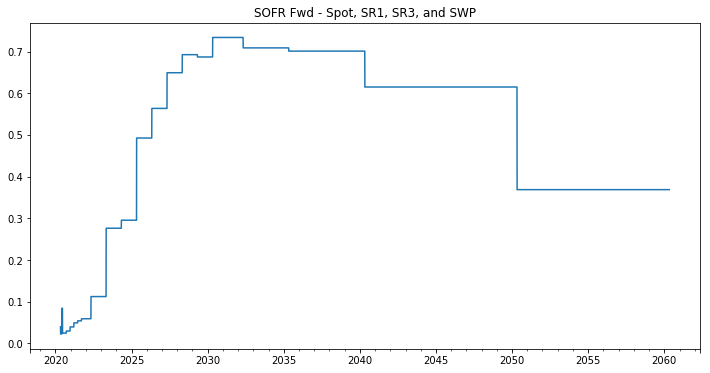

In [276]:
# We will overwrite the remaining forward rates with the ones stored in smin_all
start = ['04/30/2022', '04/30/2023', '04/30/2024', '04/30/2025', '04/30/2026', '04/30/2027',\
         '04/30/2028', '04/30/2029', '04/30/2030', '04/30/2032', '04/30/2035', '04/30/2040',\
         '04/30/2050']
end = ['04/30/2023', '04/30/2024', '04/30/2025', '04/30/2026', '04/30/2027', '04/30/2028',\
       '04/30/2029', '04/30/2030', '04/30/2032', '04/30/2035', '04/30/2040', '04/30/2050',\
       '04/30/2060']

for i in range(0,13):
    fwd_rates = set_rates(fwd_rates, smin_all[i], start[i], end[i])
    
fwd_rates.plot(title='SOFR Fwd - Spot, SR1, SR3, and SWP', figsize=(12,6))

## References

CME SR1 and SR3 futures conventions

https://www.cmegroup.com/trading/interest-rates/secured-overnight-financing-rate-futures.html#vendorCodes

CME SR1 data

https://www.cmegroup.com/trading/interest-rates/stir/one-month-sofr_quotes_globex.html

CME SR3 data

https://www.cmegroup.com/trading/interest-rates/stir/three-month-sofr_quotes_globex.html

FRB SOFR spot data

https://apps.newyorkfed.org/markets/autorates/SOFR